<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/feature_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue Apr 20 15:44:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! unzip -q /content/drive/MyDrive/blender_512.zip -d scenes

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, norm = True):
    npimg = img.numpy()
    if norm:
        npimg = (np.clip(npimg * 1.4 + 1.3, 0, 8)/8)
    npimg = npimg **0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

In [5]:
def align_one_level(ref, alt, upsampled_align_field = None, tile_size = 8, radius = 8, norm = 2):

    H, W, _ = ref.shape
    assert ref.shape == alt.shape
    assert H%tile_size == 0 and W%tile_size == 0

    if upsampled_align_field is None:
        upsampled_align_field = np.zeros((H//tile_size, W//tile_size, 2), np.int16)
    align_field = np.zeros_like(upsampled_align_field, upsampled_align_field.dtype)
    
    HH, WW, _ = upsampled_align_field.shape
    assert H//HH == tile_size and W//WW == tile_size
    
    ## non overlap
    for i in range(0, H, tile_size):
        for j in range(0, W, tile_size):
            T = ref[i:i+tile_size, j:j+tile_size]
            temp = 1e10

            for u in range(-radius, radius):
                for v in range(-radius, radius):
                    offset_u = u + upsampled_align_field[i//tile_size, j//tile_size, 0]
                    offset_v = v + upsampled_align_field[i//tile_size, j//tile_size, 1]
                    xs = i + offset_u
                    ys = j + offset_v
                    xe = xs + tile_size
                    ye = ys + tile_size

                    if xe > H or ye > W or xs < 0 or ys < 0:
                        continue

                    I_tile = alt[xs:xe, ys:ye]
                    norm_diff = np.linalg.norm(T.flatten()-I_tile.flatten(), ord=norm)
                    if norm_diff < temp:
                        temp = norm_diff
                        align_field[i//tile_size, j//tile_size, 0] = offset_u
                        align_field[i//tile_size, j//tile_size, 1] = offset_v
                        
    return align_field

def merge(ref, alt, bi_align_field, tile_size = 8, stride = 8):
    assert ref.shape == alt.shape
    H, W, C = ref.shape
    merged_frame = np.zeros_like(ref) # existance of cosine filter, dtype are different.
    for i in range(0, H, stride):
        for j in range(0, W, stride):
            T = ref[i:i+tile_size, j:j+tile_size]
            xs = i + bi_align_field[i//stride, j//stride, 0]
            ys = j + bi_align_field[i//stride, j//stride, 1]
            xe = xs + tile_size
            ye = ys + tile_size
            if xs < 0 or ys < 0 or xe > H or ye > W: ## only process lie-in-between tiles
                print("error: xs, ys, xe, ye", xs, ys, xe, ye)
                print("error: i, j, i%32, j%32", i, j, i%32, j%32)
                I_tile = T.copy()
            else:
                I_tile = alt[xs:xe, ys:ye]
            # weight = merge_distance(T, I_tile, threshold)
            # merged_tile = weight * I_tile + (1-weight) * T
            merged_frame[i:i+tile_size, j:j+tile_size] += I_tile
    return merged_frame

In [6]:
## [n_batch, 16, 3, 64, 64]

class camMosaicModelTensor:
    def __init__(self):
        ''' params that are from experiments on EVETAR camera '''
        self.sigma_r = 5.3e-4
        self.sigma_s = 8.9e-5
        self.bit_depth = 10
        self.black_level = 50
        ''' params that are NOT from experiments on EVETAR camera '''
        self.amplitude = 2 * 4

    def noise_model(self, img_gt):
        '''
        follow the noise model of signal-dependent normal distribution
        '''
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        # print(sigma_noise)
        noise = torch.randn_like(img_gt) * sigma_noise
        # print(noise.size(), noise.max(), noise.min())
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        '''
        filter a full RGB frame to be a raw frame.
        '''
        n_frame, c, h, w = img.shape
        bayer_img = torch.zeros(n_frame, 1, h, w)
        bayer_img[..., 0, ::2, ::2] = img[..., 0, ::2, ::2]
        bayer_img[..., 0, 1::2, 1::2] = img[..., 2,::2, ::2]
        bayer_img[..., 0, ::2, 1::2] = img[..., 1, ::2, 1::2]
        bayer_img[..., 0, 1::2, ::2] = img[..., 1, 1::2, ::2]
        return bayer_img

    def rgb2bayer_3chan(self, img):
        n_frame, c, h, w = img.shape
        bayer_img = torch.zeros(n_frame, 3, h, w)
        bayer_img[..., 0, ::2, ::2] = img[..., 0, ::2, ::2]
        bayer_img[..., 2, 1::2, 1::2] = img[..., 2,::2, ::2]
        bayer_img[..., 1, ::2, 1::2] = img[..., 1, ::2, 1::2]
        bayer_img[..., 1, 1::2, ::2] = img[..., 1, 1::2, ::2]
        return bayer_img

    def spatial_sampling(self, img, pix = 4):
        n_frame, c, h, w = img.shape
        return F.avg_pool2d(img, pix) * pix**2

    
    def develop(self, img_gt):
        '''
        develop raw frame from ground truth via the noise model, quantization, CFA.
        '''
        img = self.spatial_sampling(img_gt)
        img_noisy = self.noise_model(img)
        sensor_noisy = torch.clamp(torch.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer(sensor_noisy_float)
        return sensor_noisy_float, bayer_noisy_float

In [7]:
import os
import cv2

class SynDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None):
        self.root = root
        self.train = train
        self.transform = transform
        self.cam = camMosaicModelTensor()

    def __len__(self):
        if self.train:
            return 160
        else:
            return 40
    
    def __getitem__(self, index):
        i = index if self.train else index+160
        Xs = []
        for j in range(9):
            # X = load_exr(os.path.join(self.root, "scene{:04d}".format(i), 
            #                         "Image", "Image{:04d}.exr".format(j + 1)))
            X = load_exr(os.path.join(self.root, "scene{:04d}".format(i), 
                                    "Image", "Image{:04d}.exr".format(1)))
            Xs.append(X)
        Xs = np.stack(Xs)
        Xs = self.randomCrop(Xs)
        Xs = torch.from_numpy(Xs.transpose(0, 3, 1, 2)).float()
        # X, _ = self.cam.develop(Xs)

        return (Xs - 1.3)/1.4, (Xs[4] - 1.3)/1.4

    def randomCrop(self, img, size = 256):
        n_frame, H, W, C = img.shape
        # x = np.random.randint(0, H - size + 1)
        # y = np.random.randint(0, W - size + 1)
        x = np.random.randint(4, H - size - 3)
        y = np.random.randint(4, W - size - 3)
        crop_img = np.empty((n_frame, size, size, C))
        k = 0
        offset = [-4, 0, 4]
        for i in range(3):
            for j in range(3):
                crop_img[k] = img[k, x+offset[i]:x+offset[i]+size, y+offset[j]:y+offset[j]+size]
                k += 1
        return crop_img

trainset = SynDataset(root='/content/scenes', train=True, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = SynDataset(root='/content/scenes', train=False, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


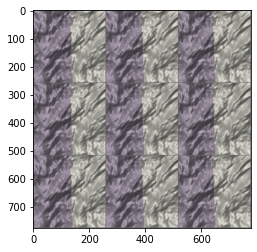

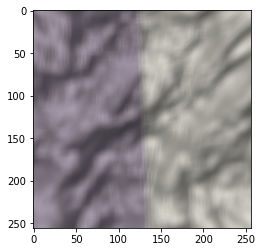

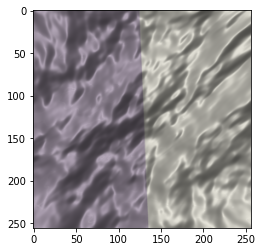

In [8]:
dataiter = iter(trainloader)
images, targets = dataiter.next()
imshow(torchvision.utils.make_grid(images[0], nrow = 3))
imshow(torchvision.utils.make_grid(images[0].mean(dim=0)))
imshow(torchvision.utils.make_grid(targets[:1]))

In [9]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True, groups=groups)

def deconv4x4(in_planes, out_planes, stride=2):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=stride, padding=1, bias=True)
    
class colorEncoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorEncoder, self).__init__()
        '''encoder'''
        self.encoder = nn.Sequential(
            conv3x3(in_planes, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, feature_planes, 2),
            nn.ReLU(inplace = True),
        )
    def forward(self, x):
        features = self.encoder(x)
        return features

class colorDecoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorDecoder, self).__init__()
        '''decoder'''
        self.decoder = nn.Sequential(
            deconv4x4(feature_planes, 256),
            nn.ReLU(inplace = True),
            deconv4x4(256, 64),
            nn.ReLU(inplace = True),
            deconv4x4(64, in_planes)
        )
    def forward(self, x):
        x = self.decoder(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
in_planes = 3
feature_planes = 128
encoder = colorEncoder(in_planes, feature_planes).to(device)
decoder = colorDecoder(in_planes, feature_planes * 9).to(device)
state_dict = torch.load('color_ae_on_512_synthetic.pt')
encoder_dict = {k: v for k, v in state_dict.items() if "encoder" in k}
encoder.load_state_dict(encoder_dict)
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False

In [10]:
print(encoder)

colorEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
)


1st features of 16 low res frames vs 1st feature of high res frame

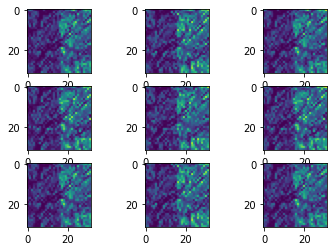

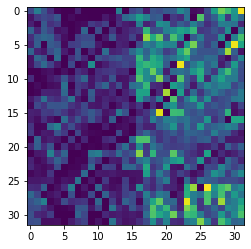

In [11]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

encoder.encoder[-1].register_forward_hook(get_activation('in_feature'))
output = encoder(images[0].to(device))
act_lr = activation['in_feature'].detach().cpu()

## first features of 9 frames
fig, axarr = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axarr[i][j].imshow(act_lr[i*3+j, 0])
plt.show()

encoder.encoder[-1].register_forward_hook(get_activation('out_feature'))
output = encoder(targets[:1].to(device))
act_hr = activation['out_feature'].detach().cpu()

plt.imshow(act_hr[0, 0])
plt.show()

In [12]:
act_lr.size()

torch.Size([9, 128, 32, 32])

In [13]:
shuffled = F.pixel_shuffle(act_lr.permute(1, 0, 2, 3), 3).permute(1, 0, 2, 3)
shuffled.size()

torch.Size([1, 128, 96, 96])

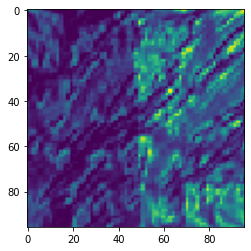

In [14]:
plt.imshow(shuffled[0, 0])
plt.show()

feature estimation

In [15]:
# def conv7x7(in_planes, out_planes, stride=1, groups=1):
#     return nn.Conv2d(in_planes, out_planes, kernel_size=7, stride=stride, padding=3, bias=True, groups=groups)

# class featureNet(nn.Module):
#     def __init__(self):
#         super(featureNet, self).__init__()
#         self.layers = nn.Sequential(
#             deconv4x4(feature_planes, 64),
#             nn.ReLU(inplace = True),
#             deconv4x4(64, 32),
#             nn.ReLU(inplace = True),
#             deconv4x4(32, in_planes)
#         )
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

#     def forward(self, x):
#         return self.layers(x)
# model = featureNet().to(device)
# print(model)
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
model = decoder
print_model_params(model)

#total params: 4984131 | #trainable params: 4984131


In [16]:
trainset = SynDataset(root='/content/scenes', train=True, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testset = SynDataset(root='/content/scenes', train=False, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

In [17]:
## train network
import torch.optim as optim
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, optimizer, n_epoch, trainloader, loss_fn):
    for epoch in range(n_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            with torch.no_grad():
                assert inputs.size(0) == 1
                inputs = inputs.squeeze() ## [9, 3, 256, 256]
                feature = encoder(inputs) ## [9, 128, 32, 32]
                n_f, c, h, w = feature.size()
                feature = feature.view(1, n_f * c, h, w)
                # feature = F.pixel_shuffle(feature.permute(1, 0, 2, 3), 4).permute(1, 0, 2, 3) 
                #                                                         ## [1, 128, 32, 32]
                # output_feature = encoder(targets) ## [1, 128, 32, 32]

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(feature)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('epoch %d -- loss: %.3f' %
                    (epoch+1, running_loss/(i+1)))
        running_loss = 0.0

    print('Finished Training')

train(model, optimizer, 20, trainloader, loss_fn)

epoch 1 -- loss: 0.220
epoch 2 -- loss: 0.058
epoch 3 -- loss: 0.046
epoch 4 -- loss: 0.041
epoch 5 -- loss: 0.050
epoch 6 -- loss: 0.034
epoch 7 -- loss: 0.023
epoch 8 -- loss: 0.019
epoch 9 -- loss: 0.029
epoch 10 -- loss: 0.026
epoch 11 -- loss: 0.051
epoch 12 -- loss: 0.019
epoch 13 -- loss: 0.016
epoch 14 -- loss: 0.014
epoch 15 -- loss: 0.014
epoch 16 -- loss: 0.023
epoch 17 -- loss: 0.020
epoch 18 -- loss: 0.014
epoch 19 -- loss: 0.045
epoch 20 -- loss: 0.021
Finished Training


In [18]:
def test(model, testloader, loss_fn):
    with torch.no_grad():
        running_loss = 0.0

        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            assert inputs.size(0) == 1
            inputs = inputs.squeeze() ## [16, 3, 64, 64]
            feature = encoder(inputs) ## [16, 128, 8, 8]
            n_f, c, h, w = feature.size()
            feature = feature.view(1, n_f * c, h, w)

            outputs = model(feature)
            loss = loss_fn(outputs, targets)

            # print statistics
            running_loss += loss.item()
        print('test loss: %.3f' %
                    (running_loss/(i+1)))
        running_loss = 0.0

    print('Finished testing')

model.eval()
test(model, testloader, loss_fn)

test loss: 0.017
Finished testing


In [19]:
dataiter = iter(testloader)
inputs, targets = dataiter.next()
inputs = inputs.to(device)
targets = targets.to(device)

assert inputs.size(0) == 1

model.eval()
with torch.no_grad():
    inputs = inputs.squeeze() ## [16, 3, 64, 64]
    feature = encoder(inputs) ## [16, 128, 8, 8]
    n_f, c, h, w = feature.size()
    feature = feature.view(1, n_f * c, h, w)

    outputs = model(feature).detach()

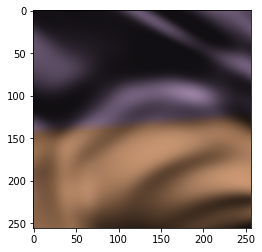

In [20]:
imshow(torchvision.utils.make_grid(inputs.cpu().mean(dim = 0)))

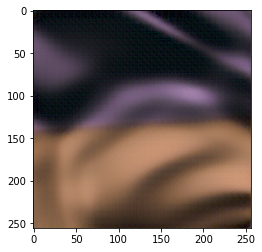

In [21]:
imshow(torchvision.utils.make_grid(outputs.cpu()))

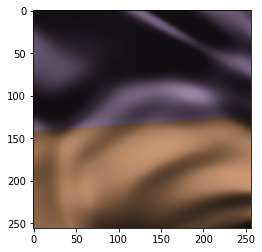

In [22]:
imshow(torchvision.utils.make_grid(targets.cpu()))

In [23]:
torch.square(outputs - targets).mean()

tensor(0.0031, device='cuda:0')